# A/B testing - Mobile Game

"Cookie Cats" is a mobile puzzle game. The player must connect tiles of same color to win the level. As players clear levels, they will encounter "gates" which will stop them from going on to the next level. Once a player encounters a gate they can choose to either unlock it by spending in-game currency or wait a certain amount of time before they can continue playing. 

#### In this project we will analyze the user data to decide whether the placement of gates at different levels significantly influences player retention times.

### The data:
* userid: unique number identifying a user
* version: Indicates whether a player encountered the gates at lvl_30 or lvl_40
* sum_gamerounds: Number or rounds played by during first 7 days after installation
* retention_1: Boolean value showing if the player came back to play after day 1.
* retention_7: Boolean value showing if the player came back to play after 1 week.

In [26]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math as mt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [17]:
df = pd.read_csv("cookie_cats.csv")

In [19]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [22]:
#check missing values
df.isnull().values.any()

False

## Control and Test data
The players were randomly assigned the game version with gates at lvl 30 or lvl 40. 

In [23]:
group_by_version = df.groupby("version").count()

In [24]:
group_by_version

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


We can also see the two groups have similar size which is good for A/B testing

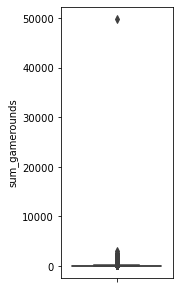

In [45]:
plt.figure(figsize=(2,5))
ax = sns.boxplot(y=df["sum_gamerounds"])


The box plot of sum_gamerounds column shows that most of the players players played anywhere from 1 to 5000 rounds during the first week. In addition, we can see an outlier in the data at around 50,000 rounds/week.

In [46]:
df["sum_gamerounds"].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Further description shows that 50% of players played fewer than 16 game rounds during the first 7 days and 75% played fewer than 51 game rounds.

In [47]:
group_by_rounds = df.groupby("sum_gamerounds").count()

In [49]:
group_by_rounds

,userid,version,retention_1,retention_7
sum_gamerounds,,,,
0,3994,3994,3994,3994
1,5538,5538,5538,5538
2,4606,4606,4606,4606
3,3958,3958,3958,3958
4,3629,3629,3629,3629
...,...,...,...,...
2294,1,1,1,1
2438,1,1,1,1
2640,1,1,1,1


#### almost 4,000 players didn't even play a single round after installing the app. And more than 14,000 players played less than 3 rounds.

Text(0, 0.5, 'number of players')

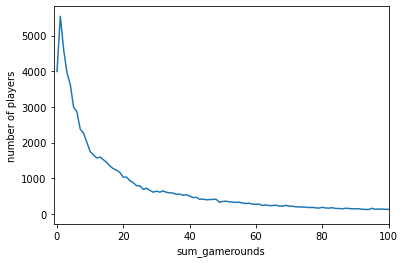

In [62]:

fig, ax = plt.subplots()
sns.lineplot(data=group_by_rounds,x=group_by_rounds.index,y="userid")
ax.set_xlim(-1,100)
plt.ylabel("number of players")


Most of the players played less than 20 rounds.
As the number of rounds played increases the number of players approaches a constant value of around 300.

In [63]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [68]:
print("number of players that came back after the first day:" ,df.retention_1.sum())

number of players that came back after the first day: 40153


In [69]:
print("number of players that stoped playing after the first day:" ,df.retention_1.count())

number of players that stoped playing after the first day: 90189


In [71]:
print("1-day retention:", df.retention_1.sum()/df.retention_1.count())

1-day retention: 0.4452095044850259


1 day retention shows the percentege of players that came back to play after 1 day of playing. In this case the percentage is about 45%.

In [72]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

We can see that there was a small change in the retention time of players over two different groups. The percentege difference of around 0.006%.

### Bootstraping
While the difference in the retention time between lvl30 and lvl40 groups was seen to be very small we need to make verify if this difference is likely to increase in the future. We can re-sample our data and calculate retention_1 for two groups in each sample. Below we can see the distributions of retention_1 for gate_30 and gate_40 groups.

<AxesSubplot:ylabel='Density'>

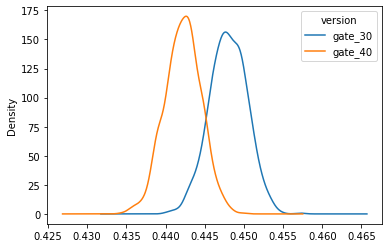

In [84]:
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

In [86]:
boot_1d["%diff"] = boot_1d["gate_30"] - boot_1d["gate_40"]

In [87]:
boot_1d

version,gate_30,gate_40,%diff
retention_1,0.452232,0.441552,0.010680
retention_1,0.450707,0.441807,0.008900
retention_1,0.451618,0.442370,0.009248
retention_1,0.447155,0.441989,0.005166
retention_1,0.448025,0.441267,0.006758
...,...,...,...
retention_1,0.447705,0.441352,0.006353
retention_1,0.444830,0.441627,0.003203
retention_1,0.446090,0.444806,0.001285
retention_1,0.447646,0.443025,0.004622


<AxesSubplot:xlabel='%diff', ylabel='Density'>

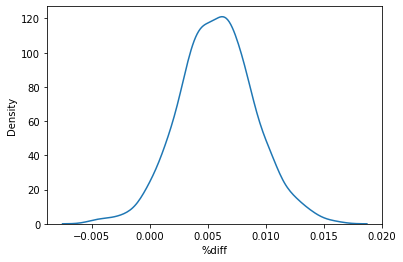

In [88]:
sns.kdeplot(data=boot_1d, x="%diff")


We can see that most of the values for the %diff between two groups are above zero. This means that in most samples the retention_1 rate for the level 30 group is greater than retention_1 time for the level 40 group.

Probability that 1 day retention is greater when the gate is placed at level 30

In [105]:
boot_1d[boot_1d["%diff"]>0].shape[0]/boot_1d["%diff"].count()

0.963

In [118]:
print("percentage of players who haven't reached lvl30")
df.groupby("sum_gamerounds").count()[:30]["userid"].sum()/df.groupby("sum_gamerounds").count()["userid"].sum()

percentage of players who haven't reached lvl30


0.6311190943463172

It makes more sense to look at 7_day retention since more players would have reached levels in the +30 range.

In [120]:
#average 7 day retention of different groups
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [136]:
a = []
for i in range(1000):
    temp = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    a.append(temp)

newDF = pd.DataFrame(a)

In [138]:
newDF["%diff"] = newDF["gate_30"]-newDF["gate_40"]

In [139]:
newDF

version,gate_30,gate_40,%diff
retention_7,0.186612,0.184092,0.002519
retention_7,0.190665,0.182977,0.007688
retention_7,0.190927,0.182624,0.008303
retention_7,0.188705,0.183975,0.004730
retention_7,0.191519,0.179721,0.011799
...,...,...,...
retention_7,0.187954,0.183831,0.004123
retention_7,0.191384,0.180436,0.010948
retention_7,0.189485,0.181415,0.008070
retention_7,0.187900,0.181378,0.006521


<AxesSubplot:xlabel='%diff', ylabel='Density'>

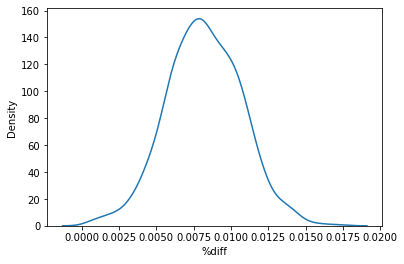

In [140]:
sns.kdeplot(data=newDF,x="%diff")

In [143]:
(newDF['%diff'] > 0).mean()

1.0

The probability of having a greater 7 day retention ratio with gates at level 30 is almost 100%.

## Conclusion

There is a significant difference in player retention between the groups. We should keep the gates at level-30 to keep the retention high. 